## Gait Video Study
### SHAP-based feature importance for Subject generalization framework in W
For local interpretation explanations, see https://www.kdnuggets.com/2019/12/interpretability-part-3-lime-shap.html

For installation, run:
* !pip install --upgrade setuptools
* !conda install -c conda-forge shap

In [1]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import subject_gen_DLtrainer, DLutils, CNN1d_model, gait_data_loader, TCN_model, LSTM_model, GRU_model, RNN_model, MULTISCALE_RESNET_model, RESNET_model
reload(subject_gen_DLtrainer)
reload(DLutils)
reload(CNN1d_model)
reload(TCN_model)
reload(LSTM_model)
reload(GRU_model)
reload(RNN_model)
reload(RESNET_model)
reload(MULTISCALE_RESNET_model)
from ml_utils.DLutils import set_random_seed, accuracy_score_multi_class
from ml_utils.subject_gen_DLtrainer import GaitTrainer
from ml_utils.CNN1d_model import CNN1D
from ml_utils.TCN_model import TCN
from ml_utils.LSTM_model import LSTM
from ml_utils.GRU_model import GRU
from ml_utils.RNN_model import RNN
from ml_utils.MULTISCALE_RESNET_model import MSResNet
from ml_utils.RESNET_model import ResNet
from ml_utils.gait_data_loader import GaitDataset
import shap

In [2]:
#Config path for the best subject gen model containing the "saved_model_path" as the 
#best model's directory and params.pt file and the best model parameters 
config_path = ".\config_files\config_template_subject_gen_shap_cnn.json"
#Fold for which we are going to use training/validation and trained model for
fold_number = 3

#Set up vars for parsing
hyperparameter_grid = {}
parameter_dict = {}

#Load config
with open(config_path) as f: 
    config_data = f.read()

config = json.loads(config_data)

#Parse through imported dictionary
for key, value in config.items():
    if 'param_' in key:
        pkey = key.replace("param_", "")
        if 'optimizer' in pkey:
            op = []
            for optim_string in value:
                op.append(optims[optim_string])
            hyperparameter_grid[pkey] = op
        else:
            hyperparameter_grid[pkey] = value
    else:
        parameter_dict[key] = value      

In [3]:
use_cuda = torch.cuda.is_available() #use_cuda is True if cuda is available 
set_random_seed(0, use_cuda) #Setting a fixed random seed for reproducibility 
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
if parameter_dict["model"]=="CNN1D":
    in_chans = hyperparameter_grid["net__module__in_chans"][0]
    out_chans = hyperparameter_grid["net__module__out_chans"][0]
    kernel_size = hyperparameter_grid["net__module__kernel_size"][0]
    stride = hyperparameter_grid["net__module__stride"][0]
    dilation = hyperparameter_grid["net__module__dilation"][0]
    groups = hyperparameter_grid["net__module__groups"][0]
    batch_norm = hyperparameter_grid["net__module__batch_norm"][0]
    dropout = hyperparameter_grid["net__module__dropout"][0]
    maxpool = hyperparameter_grid["net__module__maxpool"][0]
    maxpool_kernel_size = hyperparameter_grid["net__module__maxpool_kernel_size"][0]
    dense_out_sizes = hyperparameter_grid["net__module__dense_out_sizes"][0]
    dense_pool = hyperparameter_grid["net__module__dense_pool"][0]
    dense_pool_kernel_size= hyperparameter_grid["net__module__dense_pool_kernel_size"][0]
    dense_dropout = hyperparameter_grid["net__module__dense_dropout"][0]
    global_average_pool = hyperparameter_grid["net__module__global_average_pool"][0]
    num_classes = hyperparameter_grid["net__module__num_classes"][0] 
    time_steps = hyperparameter_grid["net__module__time_steps"][0]
    position_encoding = hyperparameter_grid["net__module__position_encoding"][0]
    model_class_ = CNN1D
    model_ = CNN1D(in_chans, out_chans, kernel_size, stride, dilation, groups, batch_norm, dropout, maxpool, maxpool_kernel_size, dense_out_sizes, dense_pool, dense_pool_kernel_size, dense_dropout, global_average_pool, num_classes, time_steps, position_encoding)

if parameter_dict["model"] == "Resnet":
    in_chans = 36
    initial_conv_layer = True
    block_name = 'basic_block' #'bottleneck' 
    layers = [1, 1, 1, 0]
    kernel_size_conv1 = 1 
    kernel_size_conv2 = 3 
    kernel_size_conv3 = 1, 
    stride_layer64 = [1, 1, 1] 
    stride_layer128 = [1, 2, 1]
    stride_layer256 = [1, 2, 1]
    stride_layer512 = [1, 2, 1]  
    position_encoding = False
    num_classes=3
    model_class_ = ResNet
    model_ = ResNet(in_chans, initial_conv_layer, block_name, layers, kernel_size_conv1, kernel_size_conv2, kernel_size_conv3, stride_layer64, stride_layer128, stride_layer256, stride_layer512, position_encoding, num_classes)
    
if parameter_dict["model"] == "MSResnet":
    in_chans = 36
    layers=[1, 1, 1, 1]
    num_classes = 3
    model_class_ = MSResNet
    model_ = MSResNet(in_chans, layers, num_classes) 
    
if parameter_dict["model"]=="TCN":
    in_chans = 36
    out_chans = 3
    num_channels = [20]*2
    kernel_size = 3
    dropout = 0.3
    model_class_ = TCN
    model_ = TCN(in_chans, out_chans, num_channels, kernel_size, dropout) 

if (parameter_dict["model"]=="LSTM") or (parameter_dict["model"]=="GRU") or (parameter_dict["model"]=="RNN"):
    in_chans = 36 #36 body coordinate features 
    hidden_size1 = 30
    num_layers1 = 3
    hidden_size2 = 20
    num_layers2 = 2
    num_classes = 3
    dropout = 0.3
    bidirectional = False
    pre_out = 50
    single_layer = False
    linear_size = 1 #Default is 1 for a single FC layer after the LSTM layers
    use_layernorm = False
    hyperparameter_grid['net__module__batch_size'] = hyperparameter_grid['net__batch_size']
    hyperparameter_grid['net__module__device1'] = [device]
    
    if parameter_dict["model"]=="LSTM":
        model_class_ = LSTM
        model_ = LSTM(in_chans, hidden_size1, num_layers1, hidden_size2, num_layers2, num_classes, dropout, bidirectional, pre_out, single_layer, linear_size, use_layernorm, hyperparameter_grid['net__module__batch_size'][0], hyperparameter_grid['net__module__device1'][0])   
    
    if parameter_dict["model"]=="GRU":
        model_class_ = GRU
        model_ = GRU(in_chans, hidden_size1, num_layers1, hidden_size2, num_layers2, num_classes, dropout, bidirectional, pre_out, single_layer, linear_size, use_layernorm, hyperparameter_grid['net__module__batch_size'][0], hyperparameter_grid['net__module__device1'][0])   
    
    if parameter_dict["model"]=="RNN":
        model_class_ = RNN
        model_ = RNN(in_chans, hidden_size1, num_layers1, hidden_size2, num_layers2, num_classes, dropout, bidirectional, pre_out, single_layer, linear_size, use_layernorm, hyperparameter_grid['net__module__batch_size'][0], hyperparameter_grid['net__module__device1'][0])   

In [5]:
trainer = GaitTrainer(parameter_dict, hyperparameter_grid, config_path)
#Initial setup for SHAP for Task Generalization 
trainer.subject_gen_shap_initial_setup(model_class_, model_, device_ = device, fold = fold_number)

Original number of subjects in trial  W  for cross validation: 32
Number of subjects in trial  W  in each cohort:
 HOA    14
MS     10
PD      8
Name: cohort, dtype: int64
Strides in trial  W  W for cross validation:  1380
HOA, MS and PD strides in trial  W  :
 HOA    658
MS     389
PD     333
Name: cohort, dtype: int64
Imbalance ratio in trial  W  (controls:MS:PD)= 1:X:Y
 HOA    1.000000
MS     0.591185
PD     0.506079
Name: cohort, dtype: float64
PIDs getting used in this run:  [212 213 214 215 216 217 218 219 310 311 312 313 314 318 320 321 322 323
 404 405 406 407 408 409 410 411 102 112 113 115 123 124]
save path:  C:\Users\Rachneet Kaur\Box\Gait Video Project\DLResults\W/CNN1D\cnn1d_shap_subject_gen_2021_05_29-01_55_09_441404/
setting random seed to:  0


In [6]:
trainer.model, trainer.X_sl_train, trainer.Y_sl_train, trainer.X_sl_test, trainer.Y_sl_test

(<class 'skorch.net.NeuralNet'>[initialized](
   module_=CNN1D(
     (pos_encoding_layer): PositionalEncoder()
     (dense_maxpool_layer): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (cnn_network): Sequential(
       (0): ConvBlock(
         (conv1): Conv1d(36, 64, kernel_size=(8,), stride=(1,))
         (batch_norm_layer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU()
         (dropout_layer): Dropout(p=0.3, inplace=False)
         (convblock_net): Sequential(
           (0): Conv1d(36, 64, kernel_size=(8,), stride=(1,))
           (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): ReLU()
           (3): Dropout(p=0.3, inplace=False)
         )
       )
       (1): ConvBlock(
         (conv1): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
         (relu): ReLU()
         (dropout_layer): Dropout(p=0, inplace=False)
         (convblock_net): S

In [7]:
#Rearranging the training data to fit the SHAP requirements 
train_body_coords = [trainer.X_sl_train[index]['body_coords'] for index in range(len(trainer.X_sl_train))]
train_body_coords = torch.stack(train_body_coords) 

train_frame_count = [trainer.X_sl_train[index]['frame_count'] for index in range(len(trainer.X_sl_train))]
train_frame_count = torch.stack(list(map(torch.tensor, train_frame_count)))

train_data = [train_body_coords, train_frame_count]
print ('Train data stats: ', len(train_data), train_data[0].shape, train_data[1].shape)

#SHAP Deep Explainer for CNN
explainer = shap.DeepExplainer(trainer.model.module, train_data)

Train data stats:  2 torch.Size([1114, 20, 36]) torch.Size([1114])


In [8]:
#Rearranging the testing data to fit the SHAP requirements 
test_body_coords = [trainer.X_sl_test[index]['body_coords'] for index in range(len(trainer.X_sl_test))]
test_body_coords = torch.stack(test_body_coords)

test_frame_count = [trainer.X_sl_test[index]['frame_count'] for index in range(len(trainer.X_sl_test))]
test_frame_count = torch.stack(list(map(torch.tensor, test_frame_count)))

test_data = [test_body_coords, test_frame_count]
print ('Test data stats: ', len(test_data), test_data[0].shape, test_data[1].shape)

#Running the SHAP explainer for test set
shap_values = explainer.shap_values(test_data)

Test data stats:  2 torch.Size([266, 20, 36]) torch.Size([266])


In [9]:
#To check the PID and thus the true label for the current test set index
#This will also help in finding the predicted label for this instance 
trainer.PID_sl_test[0]

tensor([217.])

In [10]:
#Stats for the SHAP values 
print (len(shap_values)) #Since we have 3 classes 
print (len(shap_values[0]), len(shap_values[1]), len(shap_values[2])) 
#Since we have 2 types of inputs, namely body coordinates and frame count 
print (shap_values[0][0].shape) #Since body coords is 20*36

3
2 2 2
(266, 20, 36)


In [11]:
#Postprocessing the SHAP values to reshape to num_classes x num_samples x num_features i.e. across 
#the body coords, we would need to average the 20 SHAP values for 20 time steps to one SHAP value 
#per sample and feature. 
classes = [0, 1, 2]
shaps_feature_wise = []
for class_index in classes:
    #For body coords, averaging across the 20 time steps to have one SHAP value 
    #for each instance, feature pair
    shap_body_coords = shap_values[class_index][0].mean(axis = 1)
    #For frame count
    shap_frame_count = shap_values[class_index][1].reshape(-1, 1)
    shap_feature_wise = np.concatenate((shap_body_coords, shap_frame_count), axis = 1)
    shaps_feature_wise.append(shap_feature_wise) 

In [12]:
#As the SHAP values for body coords are now one feature per sample, and thus we need to average 
#the original test set body coords values as well to have one feature per sample 
Xtest_feature_wise = np.concatenate((test_data[0].mean(axis = 1), test_data[1].reshape(-1, 1)), axis = 1)
order = ['Right Hip', 'Right Knee', 'Right Ankle', 'Left Hip', 'Left Knee', 'Left Ankle', 'Left Big Toe', 'Left Little Toe', \
         'Left Heel', 'Right Big Toe', 'Right Little Toe', 'Right Heel']
feature_names = [o + '-'+ y for o in order for y in ['x', 'y', 'z']] + ['Frame Count']
Xtest_feature_wise_df = pd.DataFrame(Xtest_feature_wise, columns= feature_names)

print (shaps_feature_wise[0].shape, Xtest_feature_wise_df.shape)

(266, 37) (266, 37)


## SHAP Vizualizations 

In [13]:
# init the JS visualization code
shap.initjs()

### Global feature importance Bar Plot 
### This has all 3 classes included in a single plot 

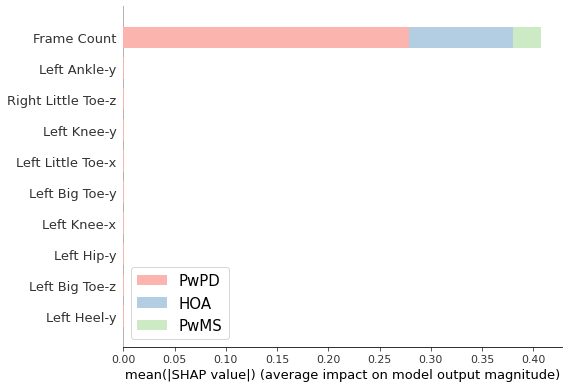

In [14]:
#Global feature importance Bar Plot 
#This has all 3 classes included in a single plot 
#max_display handles number of top important features to display
shap.summary_plot(shap_values = shaps_feature_wise, features = Xtest_feature_wise_df, plot_type='bar', \
                  class_names= ['HOA', 'PwMS', 'PwPD'], max_display=10, show=False,  color=plt.get_cmap("Pastel1"))
f = plt.gcf()
plt.tight_layout()
plt.legend(fontsize = 15)
#All plots are saved to SHAPResults directory
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_bar.png', dpi = 350)

### Global feature importance Beeswarm plot
### We need 3 different plots for 3 classes in this case 

For HOA


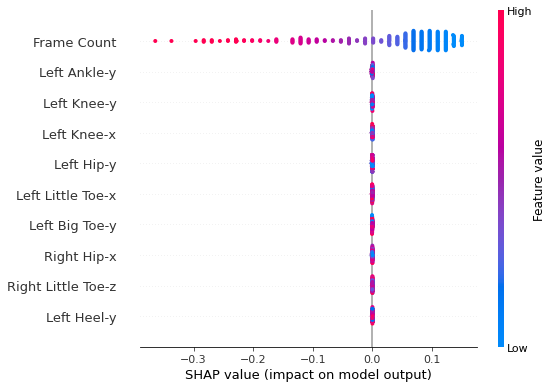

In [15]:
#Global feature importance Beeswarm plot for HOA
print ('For HOA')
#max_display handles number of top important features to display
shap.summary_plot(shap_values = shaps_feature_wise[0], features = Xtest_feature_wise_df, \
                  max_display=10, show=False)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_beeswarm_HOA.png', dpi = 350)

For PwMS


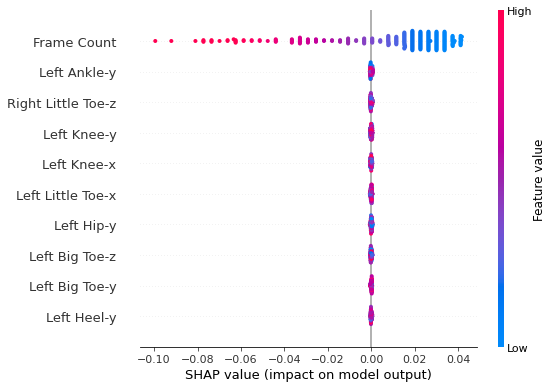

In [16]:
print ('For PwMS')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[1], features = Xtest_feature_wise_df, \
                  max_display=10, show=False)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_beeswarm_PwMS.png', dpi = 350)

For PwPD


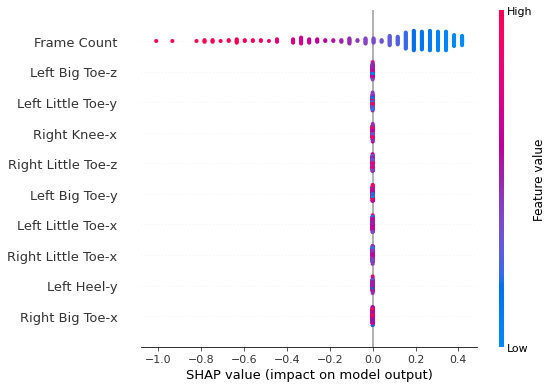

In [17]:
print ('For PwPD')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[2], features = Xtest_feature_wise_df, \
                  max_display=10, show=False)
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_beeswarm_PwPD.png', dpi = 350)

### Global feature importance Violin plot
### We need 3 different plots for 3 classes in this case 

For HOA


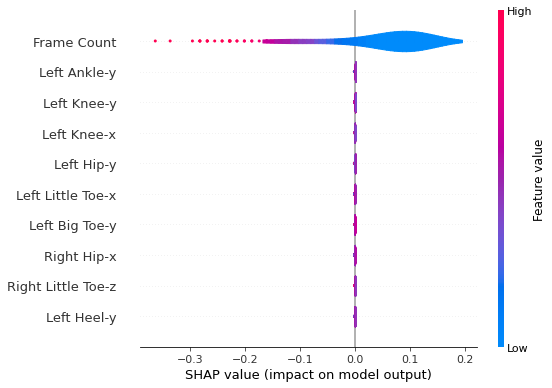

In [18]:
#Global feature importance Violin plot for HOA
print ('For HOA')
#max_display handles number of top important features to display
shap.summary_plot(shap_values = shaps_feature_wise[0], features = Xtest_feature_wise_df, \
                  max_display=10, show=False, plot_type = "violin")
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_violin_HOA.png', dpi = 350)

For PwMS


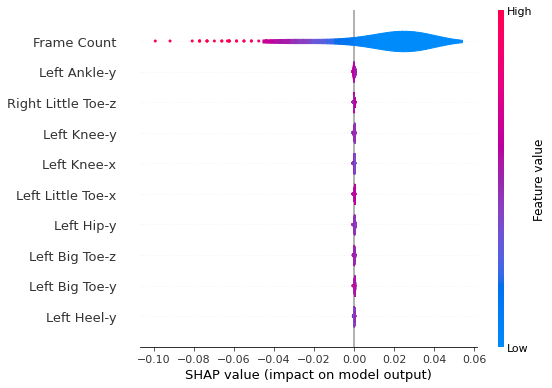

In [19]:
print ('For PwMS')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[1], features = Xtest_feature_wise_df, \
                  max_display=10, show=False, plot_type = "violin")
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_violin_PwMS.png', dpi = 350)

For PwPD


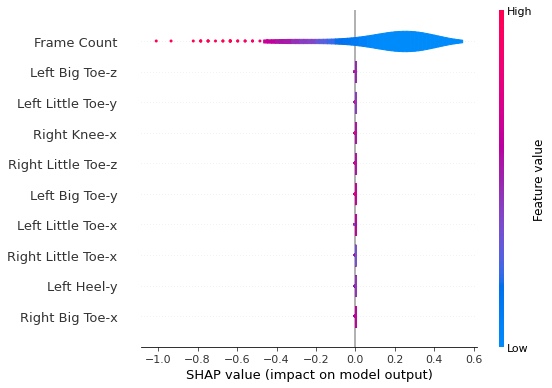

In [20]:
print ('For PwPD')
#max_display handles number of top features to display
shap.summary_plot(shap_values = shaps_feature_wise[2], features = Xtest_feature_wise_df, \
                  max_display=10, show=False, plot_type = "violin")
f = plt.gcf()
plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + '/shap_global_violin_PwPD.png', dpi = 350)

### Local feature importance force plot
### We need 3 different plots for 3 classes in this case and each plot explains a single instance 

In [21]:
#Force plot local interpretations 
#Expected value is the list of length number of classes. So, we must choose which label are we trying to explain.
#We may choose depending on the true and predicted label for the current instance we wish to explain 
print ('Expected values: ', explainer.expected_value)
classes = [0, 1, 2]
class_to_explain = 0 #0 for HOA, 1 for MS, and 2 for PD
out_names_ = ['HOA', 'PwMS', 'PwPD']
instance_to_explain = 0 #Let's explain the first test set instance 
print ('True label: ', trainer.Y_sl_test[instance_to_explain])
print ('True PID: ', trainer.PID_sl_test[instance_to_explain])

for class_to_explain in classes:
# plot the explanation of the first prediction
    force_ = shap.force_plot(
        base_value=explainer.expected_value[class_to_explain],
        shap_values=shaps_feature_wise[class_to_explain][instance_to_explain],
        features=Xtest_feature_wise_df.iloc[instance_to_explain],
        feature_names=Xtest_feature_wise_df.columns,
        link="logit",
        out_names=out_names_[class_to_explain]
    )
    #This plot doesn't display but is directly saved at the specified path 
    shap.save_html('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + \
              '/shap_local_force_instance' + str(instance_to_explain) + '_' + out_names_[class_to_explain] + '.htm', force_)

#Display all features and SHAP values
#The table below the plot is the full list of features and their 
#SHAP additive weights.
#Display all features and SHAP values for all 3 classes 
df1=pd.DataFrame(data=shaps_feature_wise[0][instance_to_explain].reshape(1,-1), \
                     columns=Xtest_feature_wise_df.columns, index=[0]).transpose().sort_values(by=0, ascending=True)
df2=pd.DataFrame(data=shaps_feature_wise[1][instance_to_explain].reshape(1,-1), \
                     columns=Xtest_feature_wise_df.columns, index=[1]).transpose().sort_values(by=1, ascending=True)
df3=pd.DataFrame(data=shaps_feature_wise[2][instance_to_explain].reshape(1,-1), \
                     columns=Xtest_feature_wise_df.columns, index=[2]).transpose().sort_values(by=2, ascending=True)
df=pd.concat([df1,df2,df3], axis = 1)
df.columns = ['HOA', 'PwMS', 'PwPD']
display(df.transpose())
#This first obvious difference is SHAP will output a seperate matrix 
#for each class prediction for the given input row. This means we have 
#3 plots to look at instead of just one. This is useful because a 
#regulator may be just as interested in why you made a decision as 
#they are in why you didn't make another.
#The units for force and decision plots are probabilities for predicting 
#the particular class for that instance vs. not that class 
#The class with the highest prediction probability is the predicted target

Expected values:  [-0.06277203 -0.00230038 -1.6016107 ]
True label:  tensor(0)
True PID:  tensor([217.])


,Frame Count,Left Ankle-y,Right Hip-x,Left Knee-y,Left Little Toe-x,Right Big Toe-z,Left Knee-x,Left Hip-y,Right Ankle-y,Left Heel-z,...,Right Knee-y,Right Little Toe-x,Left Heel-y,Right Heel-y,Left Ankle-z,Left Little Toe-y,Right Big Toe-y,Left Ankle-x,Left Big Toe-x,Right Knee-z
HOA,-0.012040,-0.000882,-0.000552,-0.000423,-0.000418,-0.000379,-0.000362,-0.000357,-0.000354,-0.000343,...,-0.000023,-0.000010,-0.000003,0.000012,0.000025,0.000029,0.000100,0.000166,0.000214,0.000324
PwMS,-0.003307,0.000499,0.000330,0.000141,0.000302,0.000207,0.000277,0.000179,0.000256,0.000193,...,-0.000066,0.000007,0.000070,-0.000110,0.000050,0.000156,-0.000142,-0.000081,-0.000073,-0.000167
PwPD,-0.033451,0.000104,-0.000024,-0.000229,0.000008,0.000117,0.000169,0.000043,0.000360,0.000104,...,0.000009,-0.000075,0.000256,-0.000310,0.000139,0.000559,-0.000060,0.000094,-0.000148,-0.000213


### Local feature importance decision plot
### We need 3 different plots for 3 classes in this case and each plot explains a single instance only

Expected values:  [-0.06277203 -0.00230038 -1.6016107 ]
True label:  tensor(0)
For  HOA
For  PwMS
For  PwPD


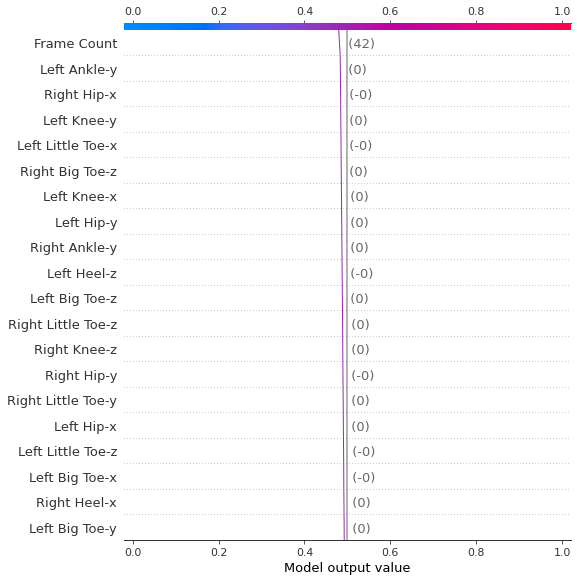

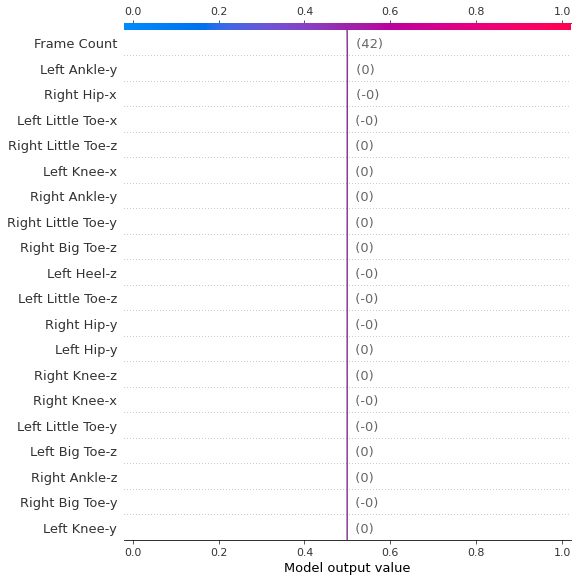

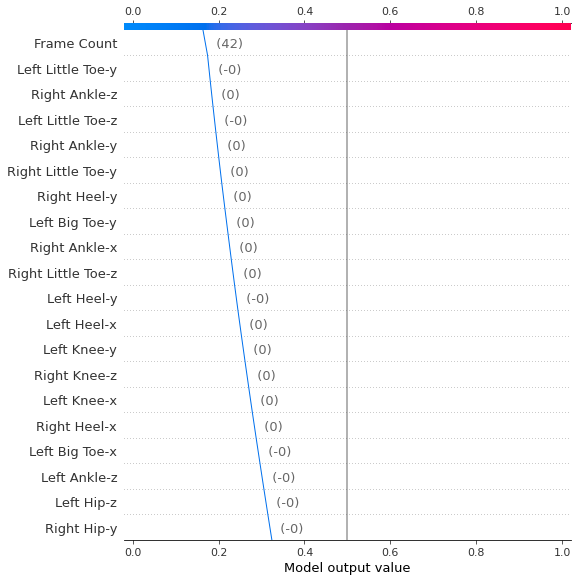

<Figure size 432x288 with 0 Axes>

In [22]:
##Decision plot local interpretations 
#Expected value is the list of length number of classes. So, we must choose which label are we trying to explain.
#We may choose depending on the true and predicted label for the current instance we wish to explain 
print ('Expected values: ', explainer.expected_value)
class_to_explain = 0 #0 for HOA, 1 for MS, and 2 for PD
instance_to_explain = 0 #Let's explain the first test set instance 
print ('True label: ', trainer.Y_sl_test[instance_to_explain])

# We provide new_base_value as the cutoff probability for the classification mode
# This is done to increase the interpretability of the plot 
new_base_value=0

for class_to_explain in classes:
    # plot the explanation of the first prediction
    shap.decision_plot(
        base_value=explainer.expected_value[class_to_explain],
        shap_values=shaps_feature_wise[class_to_explain][instance_to_explain],
        features=Xtest_feature_wise_df.iloc[instance_to_explain],
        feature_names=Xtest_feature_wise_df.columns.to_list(),
        link="logit",
        new_base_value=0,
        show = False
    )
    f = plt.gcf()
    plt.figure()
    print ('For ', out_names_[class_to_explain])
    
    plt.tight_layout()
    f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + \
          '/shap_local_decision_instance' + str(instance_to_explain) + '_' + out_names_[class_to_explain] + '.png', dpi = 350)
    f.show()

### Local feature importance multioutput decision plot
### This plots all 3 classes in a single decision plot explaining a particular single instance only (basically merges all the 3 plots above)

In [23]:
## Important ##
## We would need to manually write the predicted probabilities for 3 classes from the three force plots generated for this 
#instance we need to explain 
prob_predictions_from_force_plot = [0.48, 0.50, 0.16]

#This function assigns legend to the multioutput decision plot with cohort name and it's
#corresponding prediction probability 
def class_labels():
    return [f'Class {out_names_[i]} ({prob_predictions_from_force_plot[i]})' for i in classes]

Expected values:  [-0.06277203 -0.00230038 -1.6016107 ]
True label:  tensor(0)
For all 3 classes in same plot: 


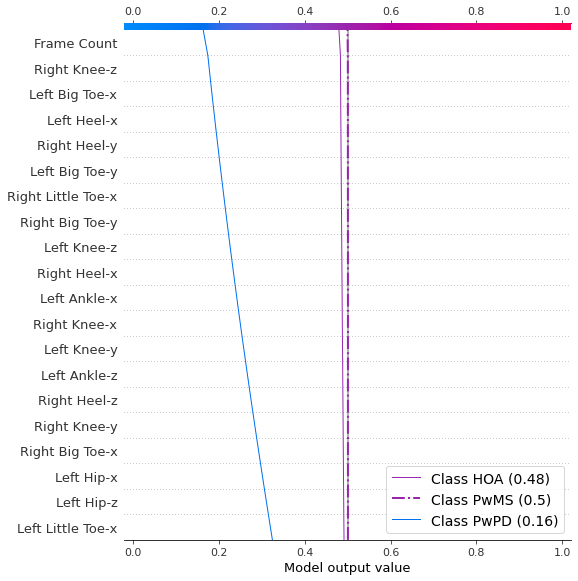

<Figure size 432x288 with 0 Axes>

In [24]:
##Decision plot local interpretations 
#Expected value is the list of length number of classes. So, we must choose which label are we trying to explain.
#We may choose depending on the true and predicted label for the current instance we wish to explain 
print ('Expected values: ', explainer.expected_value)
instance_to_explain = 0 #Let's explain the first test set instance 
print ('True label: ', trainer.Y_sl_test[instance_to_explain])

# We provide new_base_value as the cutoff probability for the classification mode
# This is done to increase the interpretability of the plot 
new_base_value=0

plt.rcParams['font.size'] = '14'

# plot the explanation of the first prediction
#Plotting all 3 cohort predictions on the same plot
shap.multioutput_decision_plot(
    base_values=list(explainer.expected_value),
    shap_values=shaps_feature_wise,
    row_index= instance_to_explain, #The instance we would like to explain 
    features=Xtest_feature_wise_df.iloc[instance_to_explain],
    feature_names=Xtest_feature_wise_df.columns.to_list(),
    link="logit", #To display the prediction probabilities on the plot
    new_base_value=0, #To have a vertical line at 0.5 for clear vizualization of predicted class 
    show = False,
    #Highlight the cohort with highest prediction probability
    highlight=[np.argmax(prob_predictions_from_force_plot)], 
    #Leged with cohort and coresponding prediction probability 
    legend_labels=class_labels(),
    legend_location='lower right'
)
f = plt.gcf()
plt.figure()
print ('For all 3 classes in same plot: ')

plt.tight_layout()
f.savefig('../SHAPResults/' + parameter_dict["framework"] + '/' + parameter_dict["model"] + \
      '/shap_local_multioutput_decision_instance' + str(instance_to_explain) + '.png', dpi = 350)
f.show()